In [1]:
import jax
import jax.numpy as jnp
import optax
import flax.nnx as nnx
from flax.training import train_state
from sklearn.model_selection import train_test_split
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import jax
import jax.numpy as jnp
import flax.nnx as nnx
from jax import random
from flax import serialization
import json
import optax
import numpy as np
from sklearn.utils.estimator_checks import check_is_fitted
from sklearn.base import BaseEstimator, _fit_context
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import r2_score
from sklearn.pipeline import Pipeline
from tqdm.notebook import tqdm # progress bar
from sklearn.preprocessing import StandardScaler
import logging
from tqdm import trange
from matplotlib.pyplot import plot
import joblib
import msgpack
import pathlib

In [2]:
features = np.loadtxt("../Data/Training_data/holes_features.txt")[:,2:]#.reshape(-1,1)
labels = np.loadtxt("../Data/Training_data/holes_labels.txt")[:,[0]]



print(features.shape)

features = np.delete(features, [3,4], axis=1)



print(features.shape)

(1562211, 8)
(1562211, 6)


In [3]:
# Split into train/test
X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.2, random_state=42)

# Standardize input features (only fit on training data!)
scaler = StandardScaler()


X_train = scaler.fit_transform(X_train)
joblib.dump(scaler, 'scaler.pkl')
X_test = scaler.transform(X_test)

X_grid, _, y_grid, _ = train_test_split(X_train, y_train, train_size=0.4, random_state=42) # Only using 40% of the data for gridsearching

# Convert to JAX arrays
X_train = jnp.array(X_train, dtype=jnp.float32)
y_train = jnp.array(y_train, dtype=jnp.float32)

X_test = jnp.array(X_test, dtype=jnp.float32)
y_test = jnp.array(y_test, dtype=jnp.float32)

# X_grid = jnp.array(X_grid, dtype=jnp.float32)
# y_grid = jnp.array(y_grid, dtype=jnp.float32)

In [4]:
X_train.shape

(3960483, 6)

In [5]:
# Your MLP model
class MLP(nnx.Module):
    def __init__(self, din, dout, rngs: nnx.Rngs):
        self.linear1 = nnx.Linear(din, 64, rngs=rngs)
        self.linear2 = nnx.Linear(64, 128, rngs=rngs)
        self.linear3 = nnx.Linear(128, 128, rngs=rngs)
        self.linear4 = nnx.Linear(128, 64, rngs=rngs)
        self.linear5 = nnx.Linear(64, dout, rngs=rngs)

    def __call__(self, x):
        x = nnx.relu(self.linear1(x))
        x = nnx.relu(self.linear2(x))
        x = nnx.relu(self.linear3(x))
        x = nnx.relu(self.linear4(x))
        return self.linear5(x)

# Init
model = MLP(X_train.shape[1], 1, rngs=nnx.Rngs(0))
optimizer = nnx.Optimizer(model, optax.adam(1e-3))

# Train step
@nnx.jit
def train_step(model, optimizer, x, y):
    def loss_fn(model):
        preds = model(x)
        return jnp.mean((preds - y) ** 2)

    loss, grads = nnx.value_and_grad(loss_fn)(model)
    optimizer.update(grads)
    return loss

r2_test_history = []
# Training loop
batch_size = 200000  # Choose a smaller batch size!

for epoch in trange(1000, desc="Training"):
    # Shuffle the data at the start of each epoch
    perm = jax.random.permutation(jax.random.PRNGKey(epoch), len(X_train))
    X_train_shuffled = X_train[perm]
    y_train_shuffled = y_train[perm]

    # Mini-batch training
    for i in range(0, len(X_train), batch_size):
        x_batch = X_train_shuffled[i:i+batch_size]
        y_batch = y_train_shuffled[i:i+batch_size]
        loss = train_step(model, optimizer, x_batch, y_batch)
        loss.block_until_ready()  # <- Add this!

    # Evaluate on the whole test set
    y_pred_test = optimizer.model(X_test)
    r2_test = r2_score(y_test, np.array(y_pred_test))
    r2_test_history.append(r2_test)



Training: 100%|██████████| 1000/1000 [07:06<00:00,  2.35it/s]


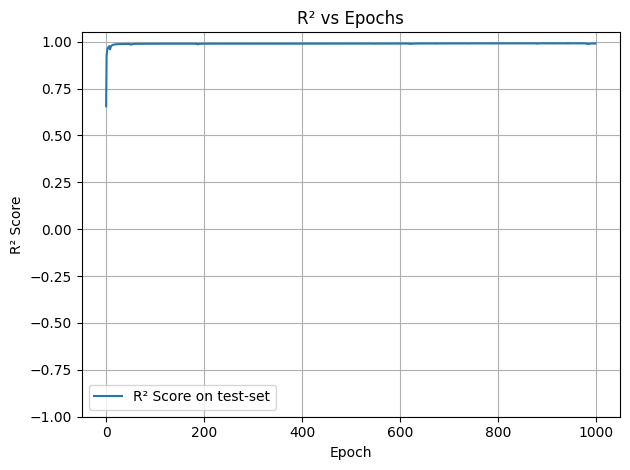

In [6]:
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt

plt.figure()
epochs = list(range(len(r2_test_history)))  # assuming both lists are the same length

# Plotting both curves

plt.plot(epochs, r2_test_history, label="R² Score on test-set")

# Styling
plt.xlabel("Epoch")
plt.ylabel("R² Score")
plt.title("R² vs Epochs")
plt.ylim(-1, 1.05)
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


In [14]:
plot_r2_progress(r2_history)

NameError: name 'plot_r2_progress' is not defined

In [7]:
# Predict
y_pred = optimizer.model(X_test)


In [8]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, max_error
import numpy as np

# y_true: your ground truth values
# y_pred: your model's predictions

def print_regression_metrics(y_true, y_pred):
    mse = mean_squared_error(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_true, y_pred)
    max_err = max_error(y_true, y_pred)

    print(f"📈 Regression Evaluation Metrics")
    print(f"--------------------------------")
    print(f"R² Score         : {r2:.4f}")
    print(f"Mean Absolute Error (MAE): {mae:.4f}")
    print(f"Mean Squared Error (MSE): {mse:.4f}")
    print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
    print(f"Max Error        : {max_err:.4f}")

In [9]:
print_regression_metrics(y_test, y_pred)

📈 Regression Evaluation Metrics
--------------------------------
R² Score         : 0.9908
Mean Absolute Error (MAE): 0.0329
Mean Squared Error (MSE): 0.0069
Root Mean Squared Error (RMSE): 0.0832
Max Error        : 1.7001


In [10]:
test_features = np.loadtxt("../Data/Training_data/testcloud_feat_1mm.txt")[:,2:]#.reshape(-1,1)
test_labels = np.loadtxt("../Data/Training_data/testcloud_lab_1mm.txt")[:,[0]]

test_features2 = np.loadtxt("../Data/Training_data/testcloud_feat_05.txt")[:,2:]#.reshape(-1,1)
test_labels2 = np.loadtxt("../Data/Training_data/testcloud_lab_05.txt")[:,[0]]


test_features3 = np.loadtxt("../Data/Training_data/testcloud_feat_2mm.txt")[:,2:]#.reshape(-1,1)
test_labels3 = np.loadtxt("../Data/Training_data/testcloud_lab_2mm.txt")[:,[0]]

test_features = np.delete(test_features, [3,4], axis=1)
test_features2 = np.delete(test_features2, [3,4], axis=1)
test_features3 = np.delete(test_features3, [3,4], axis=1)


mesh = np.hstack((np.full(len(test_features),1), np.full(len(test_features2),0.5), np.full(len(test_features3),2)))

test_features = np.vstack((test_features,test_features2,test_features3))
test_labels = np.vstack((test_labels,test_labels2,test_labels3))

scaler_reload = joblib.load('scaler.pkl')
X_test2 = scaler_reload.transform(test_features)

X_test2 = jnp.array(X_test2, dtype=jnp.float32)
y_test2 = jnp.array(test_labels, dtype=jnp.float32)


hole_features = np.loadtxt("../Data/Training_data/Gear_w_holes_features_50_5.txt")[:,2:]#.reshape(-1,1)



hole_features = np.delete(hole_features, [3,4], axis=1)

X_test_holes = scaler_reload.transform(hole_features)




In [11]:
# Predict
y_pred2 = optimizer.model(X_test2)
y_pred_holes =optimizer.model(X_test_holes)

Standard deviation for 0.5mm mesh: 0.055461667
Standard deviation for 1mm mesh: 0.034509737
Standard deviation for 2mm mesh: 0.0352123
📈 Regression Evaluation Metrics
--------------------------------
R² Score         : 0.9949
Mean Absolute Error (MAE): 0.0416
Mean Squared Error (MSE): 0.0040
Root Mean Squared Error (RMSE): 0.0634
Max Error        : 1.3065


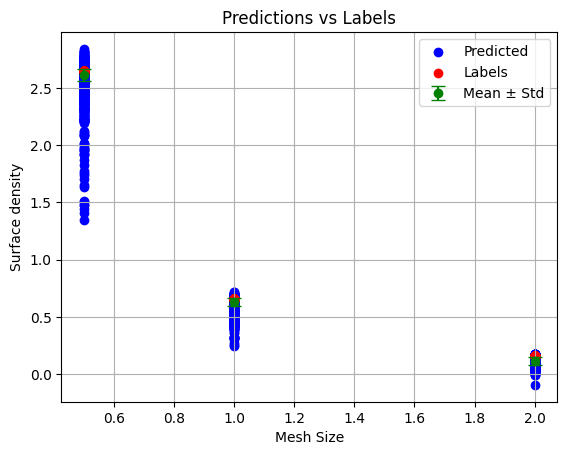

In [12]:
highest = np.max(y_pred2)
mean = np.mean(y_pred2)
#print(test_labels)
#print(mean)
#print(y_pred2)

pred_05 = y_pred2[np.where(mesh == 0.5)]
pred_1 = y_pred2[np.where(mesh == 1)]
pred_2 = y_pred2[np.where(mesh == 2)]

std_05 = np.std(pred_05)
std_1 = np.std(pred_1)
std_2 = np.std(pred_2)
stds = [std_05, std_1, std_2]

print("Standard deviation for 0.5mm mesh:", std_05)
print("Standard deviation for 1mm mesh:", std_1)
print("Standard deviation for 2mm mesh:", std_2)

mean_05 = np.mean(pred_05)
mean_1 = np.mean(pred_1)
mean_2 = np.mean(pred_2)

mesh_short = [0.5, 1, 2]
means = [mean_05, mean_1, mean_2]

print_regression_metrics(y_test2, y_pred2)
#r2 = r2_score(y_test2,y_pred2)
#print(r2)

plt.scatter(mesh, y_pred2, color='blue', label='Predicted')
plt.scatter(mesh, y_test2, color='red', label='Labels')
plt.errorbar(mesh_short, means, yerr=stds, fmt='o', color='green', capsize=5, label='Mean ± Std')
plt.xlabel("Mesh Size")
plt.ylabel("Surface density")
plt.title("Predictions vs Labels")
plt.legend()
plt.grid(True)
plt.show()

## Different mesh sizes


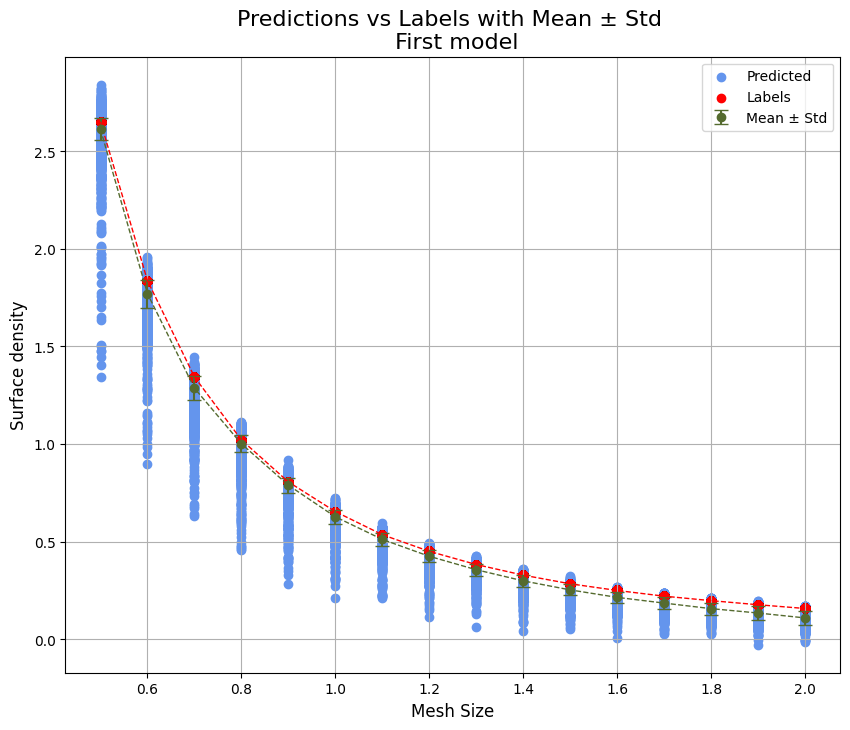

In [13]:
import numpy as np
import jax.numpy as jnp
import matplotlib.pyplot as plt
import os
save_path = os.path.join(os.getcwd(), "predict_vs_label_first.png")

# Load your data
test_features = np.loadtxt("../Data/Training_data/Chain_whee_features.txt")[:, 2:]
test_labels = np.loadtxt("../Data/Training_data/Chain_whee_labels.txt")[:, [0]]
mesh_size = np.loadtxt("../Data/Training_data/Chain_whee_labels.txt")[:, [1]]

test_features = np.delete(test_features, [3, 4], axis=1)

# Scaling
scaler_reload = joblib.load('scaler.pkl')
X_test_intevals = scaler_reload.transform(test_features)

# Convert to JAX arrays
X_test_intevals = jnp.array(X_test_intevals, dtype=jnp.float32)
y_test_intevals = jnp.array(test_labels, dtype=jnp.float32)

# Model prediction
y_pred_intevals = optimizer.model(X_test_intevals)

# Convert mesh size and predictions to numpy for easier handling
mesh_size_np = np.squeeze(np.array(mesh_size))
y_pred_np = np.squeeze(np.array(y_pred_intevals))

# Compute mean and std for each unique mesh size
unique_mesh_sizes = np.unique(mesh_size_np)
means = []
stds = []

for mesh in unique_mesh_sizes:
    mask = mesh_size_np == mesh
    mesh_preds = y_pred_np[mask]
    mean_pred = np.mean(mesh_preds)
    std_pred = np.std(mesh_preds)
    means.append(mean_pred)
    stds.append(std_pred)

# Plot

plt.figure(figsize=(10, 8))

# Scatter plot for predictions and labels
plt.scatter(mesh_size_np, y_pred_np, color='cornflowerblue', label='Predicted')
plt.scatter(mesh_size_np, np.squeeze(np.array(y_test_intevals)), color='red', label='Labels')

# Error bars for mean ± std
plt.errorbar(unique_mesh_sizes, means, yerr=stds, fmt='o', color='darkolivegreen', capsize=5, label='Mean ± Std')

# Line connecting the label points (labels)
# Sort the data to ensure lines connect in mesh_size order
sort_idx_labels = np.argsort(mesh_size_np)
plt.plot(mesh_size_np[sort_idx_labels],
         np.squeeze(np.array(y_test_intevals))[sort_idx_labels],
         color='red', linestyle='--', linewidth=1)

# Line connecting the mean predictions
sort_idx_means = np.argsort(unique_mesh_sizes)
plt.plot(unique_mesh_sizes[sort_idx_means],
         np.array(means)[sort_idx_means],
         color='darkolivegreen', linestyle='--', linewidth=1)

# Labels and title
plt.xlabel("Mesh Size", fontsize=12)
plt.ylabel("Surface density", fontsize=12)
plt.title("Predictions vs Labels with Mean ± Std \n First model",fontsize=16)
plt.legend()
plt.grid(True)

# plt.savefig(save_path, dpi=2000, bbox_inches='tight')
plt.show()

## Visualization on parts


In [14]:
cloud_05 = np.loadtxt("../../Leihui Code/dataset/SelfGeneratedClouds/Chain_wheel_05.xyz")
cloud_1 = np.loadtxt("../../Leihui Code/dataset/SelfGeneratedClouds/Chain_wheel_1mm.xyz")
cloud_2 = np.loadtxt("../../Leihui Code/dataset/SelfGeneratedClouds/Chain_wheel_2mm.xyz")

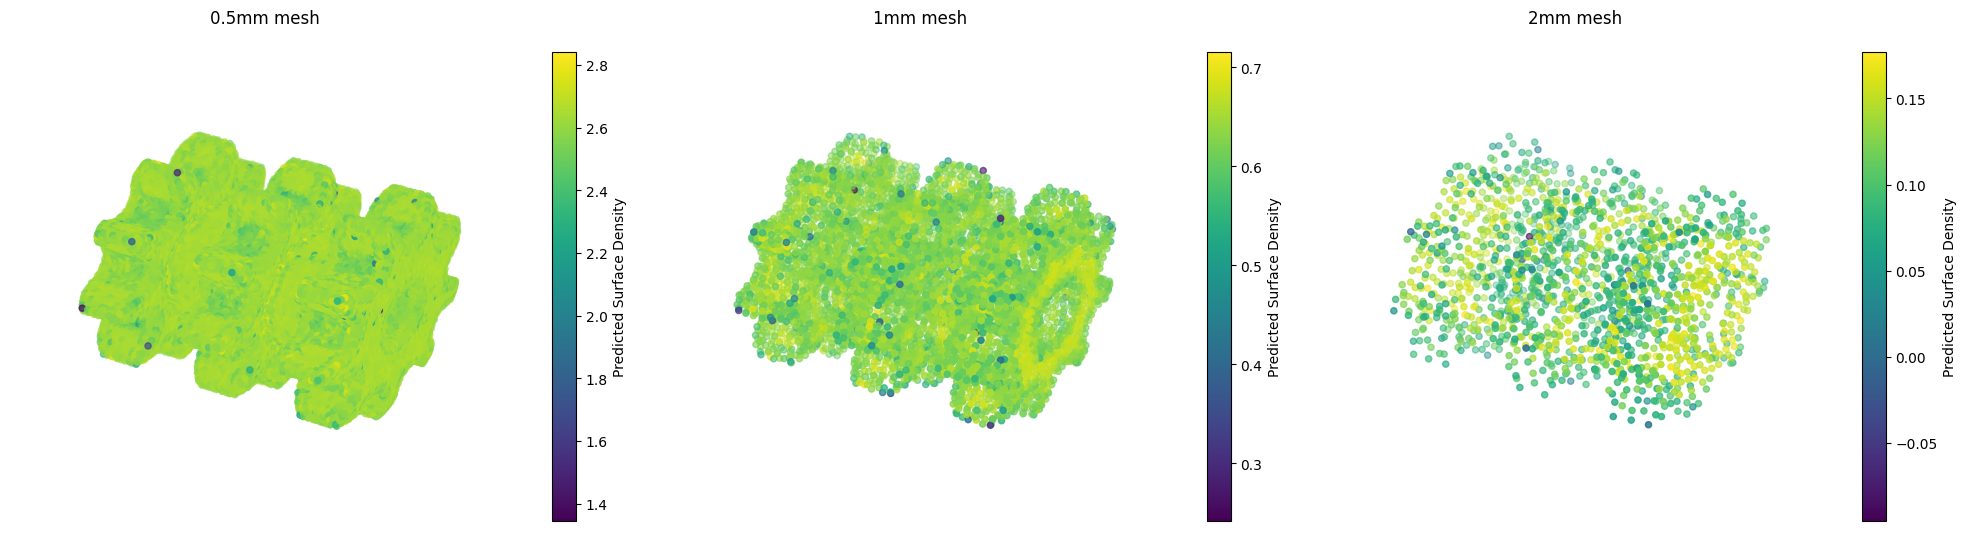

In [15]:
from mpl_toolkits.mplot3d import Axes3D

import matplotlib.pyplot as plt

# Prepare point clouds and predictions
clouds = [cloud_05, cloud_1, cloud_2]
preds = [pred_05, pred_1, pred_2]
titles = ["0.5mm mesh", "1mm mesh", "2mm mesh"]

fig = plt.figure(figsize=(20, 7))
for i, (cloud, pred, title) in enumerate(zip(clouds, preds, titles)):
    ax = fig.add_subplot(1, 3, i+1, projection='3d')
    sc = ax.scatter(cloud[:, 0], cloud[:, 1], cloud[:, 2], c=pred.flatten(), cmap='viridis')
    ax.set_title(title)
    ax.set_axis_off()
    fig.colorbar(sc, ax=ax, shrink=0.7, label='Predicted Surface Density')

plt.tight_layout()
plt.show()

In [ ]:
cloud 

In [13]:
%matplotlib Widget

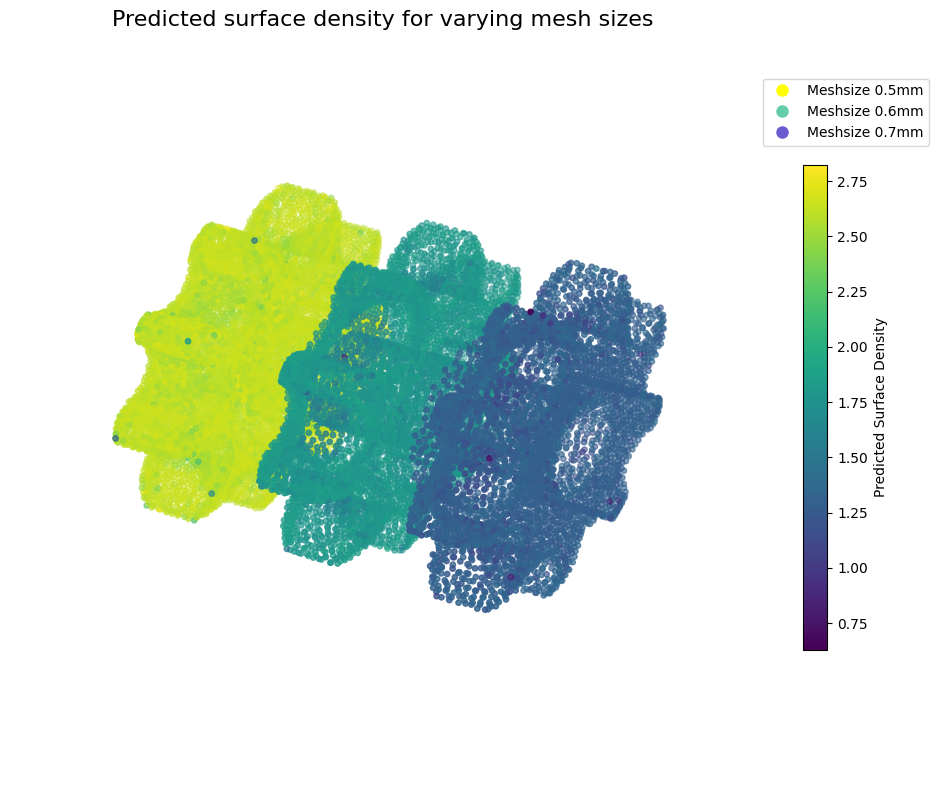

In [67]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.lines import Line2D
save_path2 = os.path.join(os.getcwd(), "varying_meshsize.png")

# Load point cloud
cloud = np.loadtxt("../Data/Training_data/varying_mesh_cloud.txt")
hole_features = np.loadtxt("../Data/Training_data/varying_mesh_features.txt")
hole_features = np.delete(hole_features, [3, 4], axis=1)

# Transform features
X_test_holes = scaler_reload.transform(hole_features)
y_pred_holes2 = optimizer.model(X_test_holes)
pred_transformed = y_pred_holes2.flatten()

title = "Predicted surface density for varying mesh sizes"

fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# Plot cloud
sc = ax.scatter(cloud[:, 0], cloud[:, 1], cloud[:, 2],
                 c=pred_transformed, cmap='viridis', s=15)

ax.set_title(title, fontsize=16)
ax.set_axis_off()

# Add colorbar
fig.colorbar(sc, ax=ax, shrink=0.65, label='Predicted Surface Density')

# Enable grid lines in 3D
ax.xaxis._axinfo["grid"].update(color="grey", linestyle="--")
ax.yaxis._axinfo["grid"].update(color="grey", linestyle="--")
ax.zaxis._axinfo["grid"].update(color="grey", linestyle="--")

# Artificial legend
legend_elements = [
    Line2D([0], [0], marker='o', color='w', label='Meshsize 0.5mm',
           markerfacecolor='yellow', markersize=10),
    Line2D([0], [0], marker='o', color='w', label='Meshsize 0.6mm',
           markerfacecolor='mediumaquamarine', markersize=10),
    Line2D([0], [0], marker='o', color='w', label='Meshsize 0.7mm',
           markerfacecolor='slateblue', markersize=10)
]
ax.legend(handles=legend_elements,
          loc='upper left',       # relative to the entire figure
          bbox_to_anchor=(1, 0.95))  # x=1.05 (right of plot), y=1 (top))
plt.tight_layout()
plt.savefig(save_path2, dpi=2000, bbox_inches='tight')

plt.show()
# NOTE NOTE Actual surface densities: 0.5: 2,64 - 0.6: 1.84 - 0.7: 1.34 NOTE NOTE

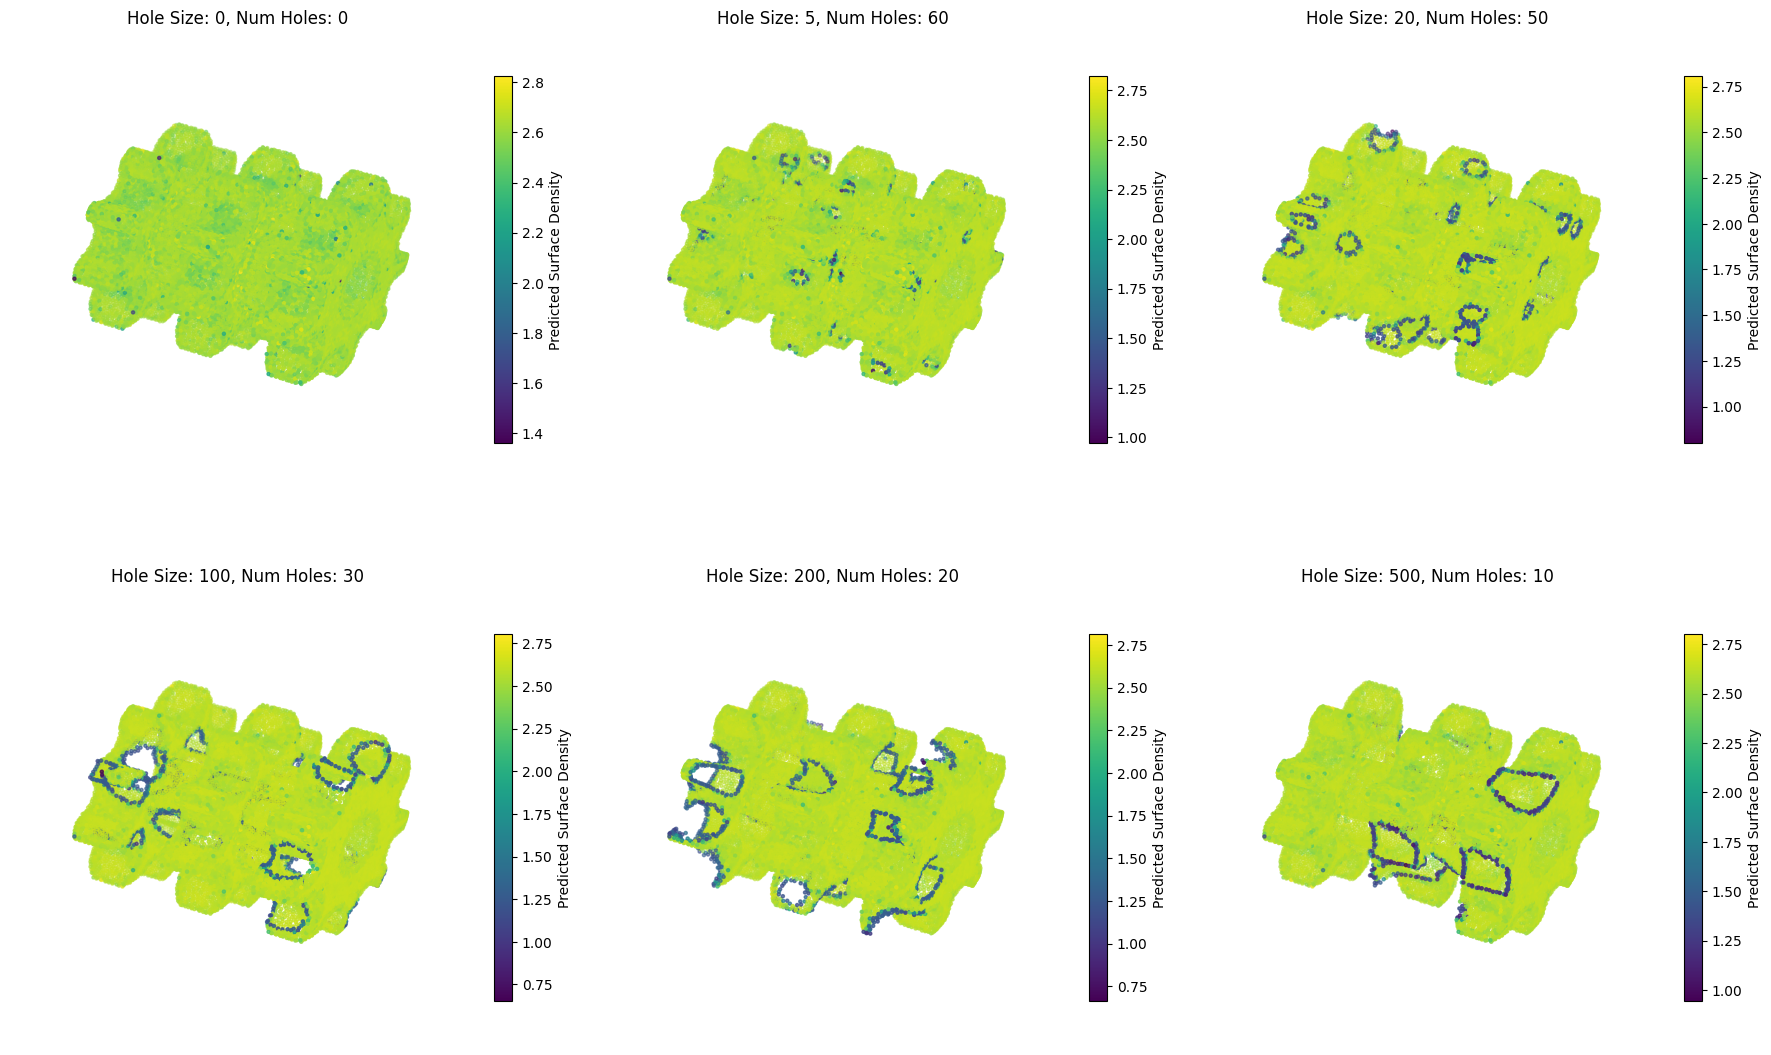

In [85]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import joblib
save_path = os.path.join(os.getcwd(), "result3.png")
# Load your scaler and model
scaler_reload = joblib.load("scaler.pkl")

# hole_configs
hole_configs = [
    (0,0),
    (5, 60),
    (20, 50),
    (100, 30),
    (200, 20),
    (500, 10)
]

# Set up grid
num_plots = len(hole_configs)
rows = 2
cols = int(np.ceil(num_plots / rows))

fig = plt.figure(figsize=(cols * 6, rows * 6))

for idx, (hole_size, num_holes) in enumerate(hole_configs):
    # Load point cloud
    cloud_path = f"../Data/Training_data/Gear_w_holes_{hole_size}_{num_holes}.txt"
    cloud = np.loadtxt(cloud_path)

    # Load features
    features_path = f"../Data/Training_data/Gear_w_holes_features_{hole_size}_{num_holes}.txt"
    hole_features = np.loadtxt(features_path)[:, 2:]
    hole_features = np.delete(hole_features, [3, 4], axis=1)  # Remove 4th & 5th columns

    # Scale features
    X_test_holes = scaler_reload.transform(hole_features)

    # Predict
    y_pred_holes = optimizer.model(X_test_holes).flatten()

    # Plot
    ax = fig.add_subplot(rows, cols, idx + 1, projection='3d')
    sc = ax.scatter(cloud[:, 0], cloud[:, 1], cloud[:, 2],
                     c=y_pred_holes, cmap='viridis', s=5)
    ax.set_title(f"Hole Size: {hole_size}, Num Holes: {num_holes}")
    ax.set_axis_off()
    fig.colorbar(sc, ax=ax, shrink=0.6, pad=0.05, label='Predicted Surface Density')

plt.tight_layout()


plt.savefig(save_path, dpi=1000, bbox_inches='tight')
plt.show()
